In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
train_start = 1976
validation_end = 2010
n_components_sst = 57
f = 12
tau = 3
cc = "ET"

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
#original_count, count = ff.drought_timeseries("../ET_gamma_18912015.npy",train_start[ijz],validation_end[ijz])
#data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

In [4]:
pcmci = np.load("../../whole_data_results/ET_orac/best_link/pcmci_{}_{}_{}_{}_{}.npy".format(f,train_start,validation_end,tau,n_components_sst))
corr = np.load("../../whole_data_results/ET_orac/best_link/corr_{}_{}_{}_{}_{}.npy".format(f,train_start,validation_end,tau,n_components_sst))

In [ ]:
link_caus = np.load("../../whole_data_results/ET_orac/best_link_all_1930_2000_{}.npy".format(tau))
link_corr = np.load("../../whole_data_results/Et_orac/best_link_all_corr_1930_2000_{}.npy".format(tau))

In [8]:
sst = Data('../../../nc/sst.mnmean.nc',"sst",temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)


Vr, Rot = rung.varimax(V)
Vr = rung.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

for i in range(n_components_sst):
    df_sst["pc"] = Vr[:,i]
    comps_ts[:,i] = ff.time_series_maker(i, df_sst, result_sst)

In [9]:
cc = 'ZW'

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value enco

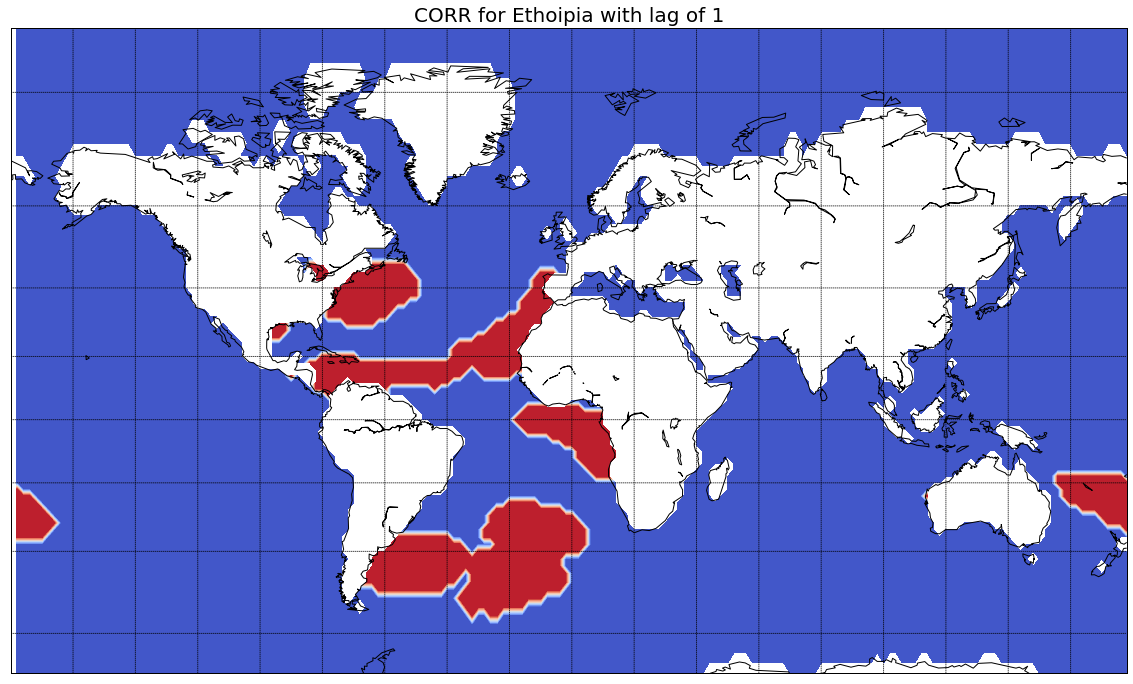

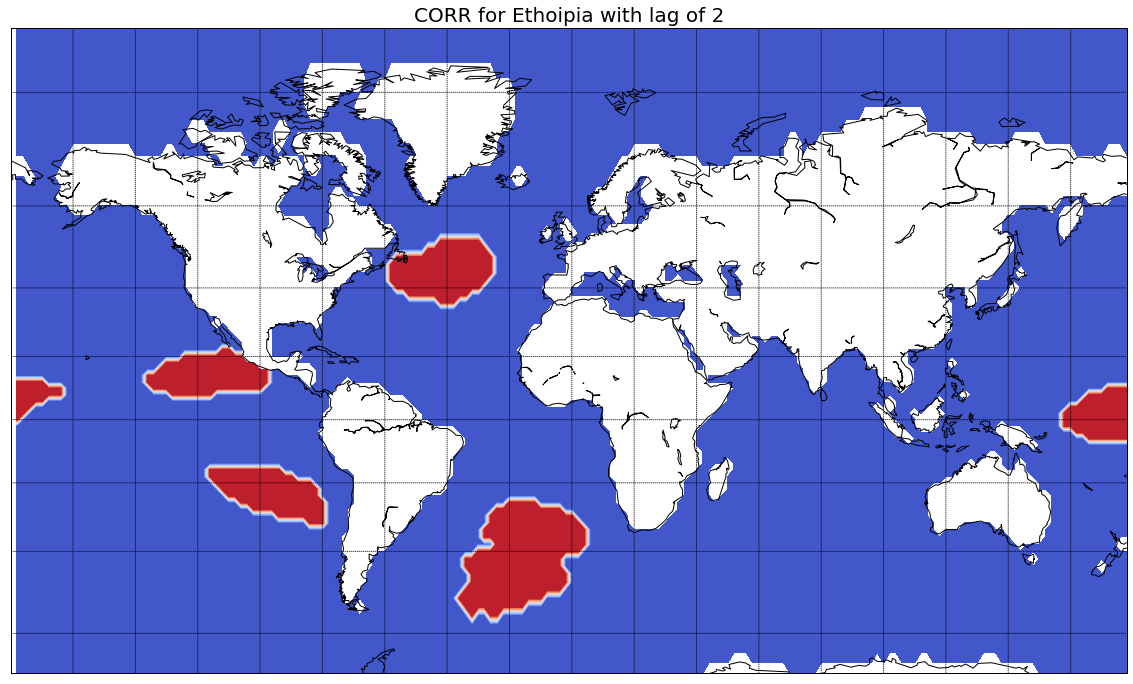

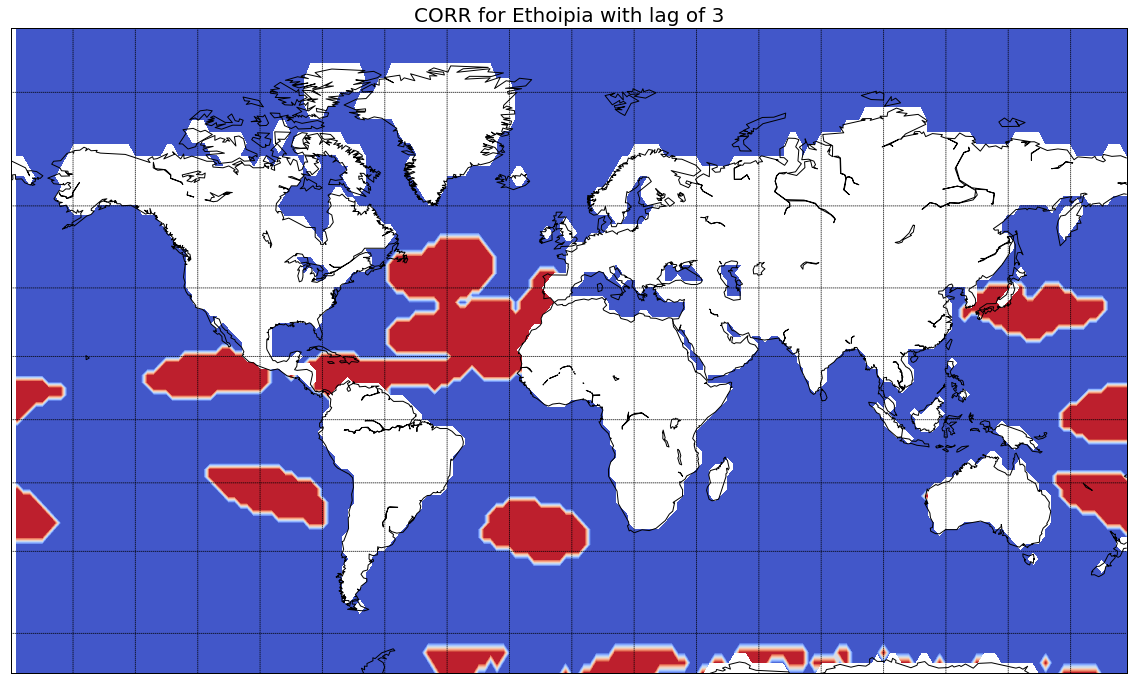

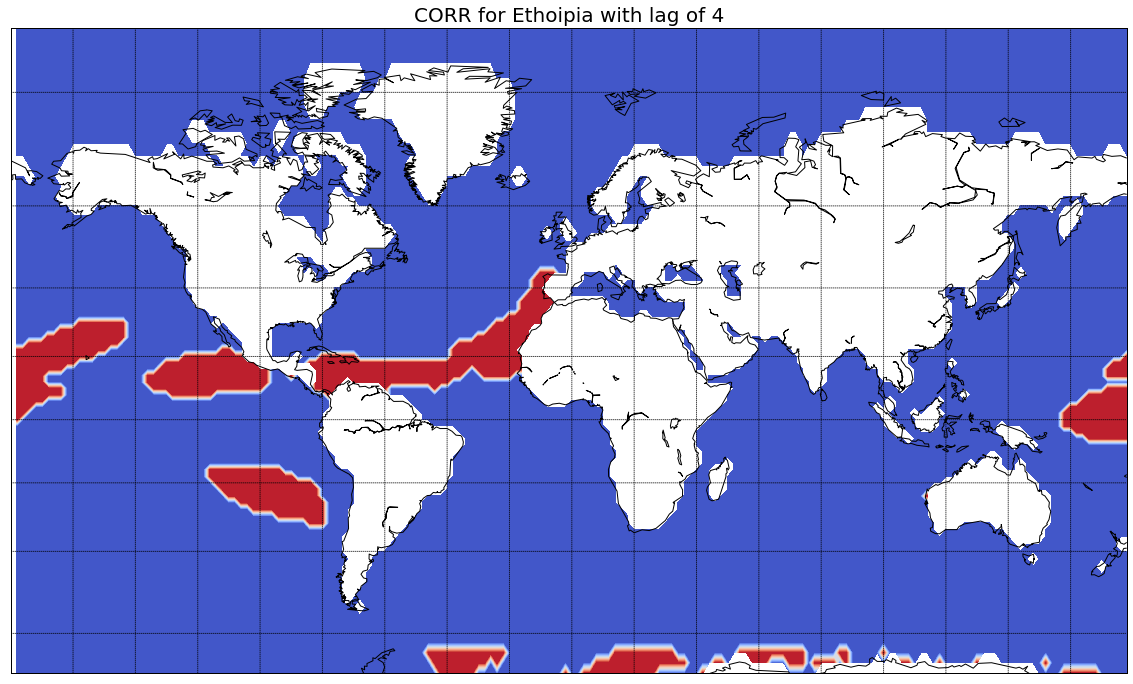

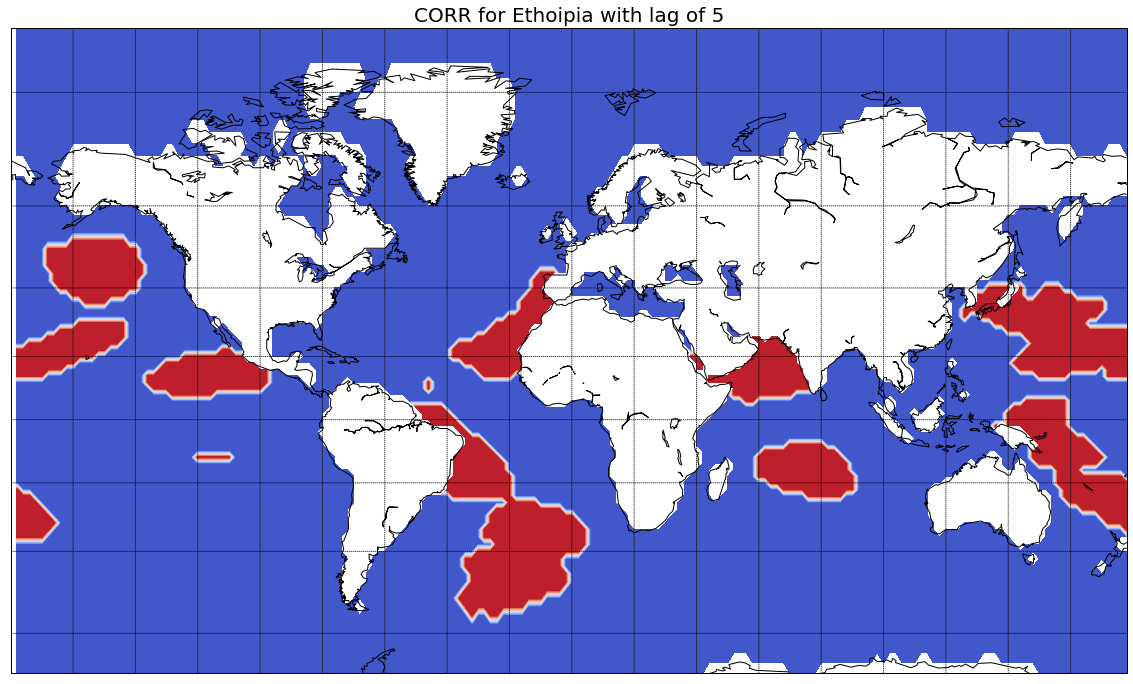

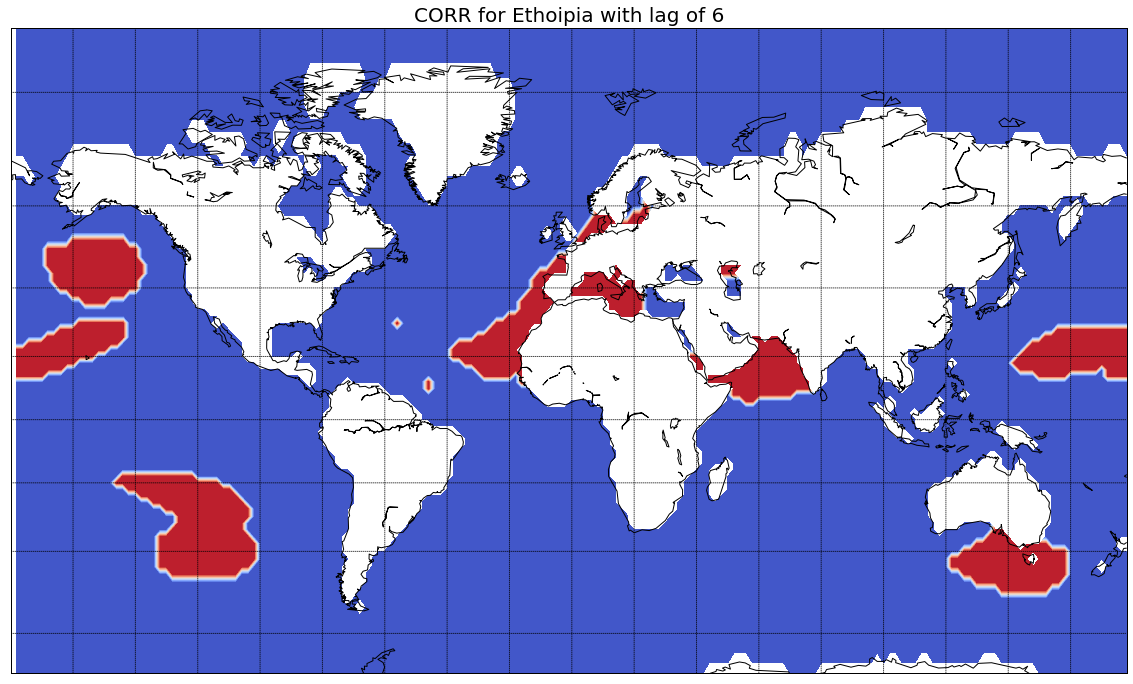

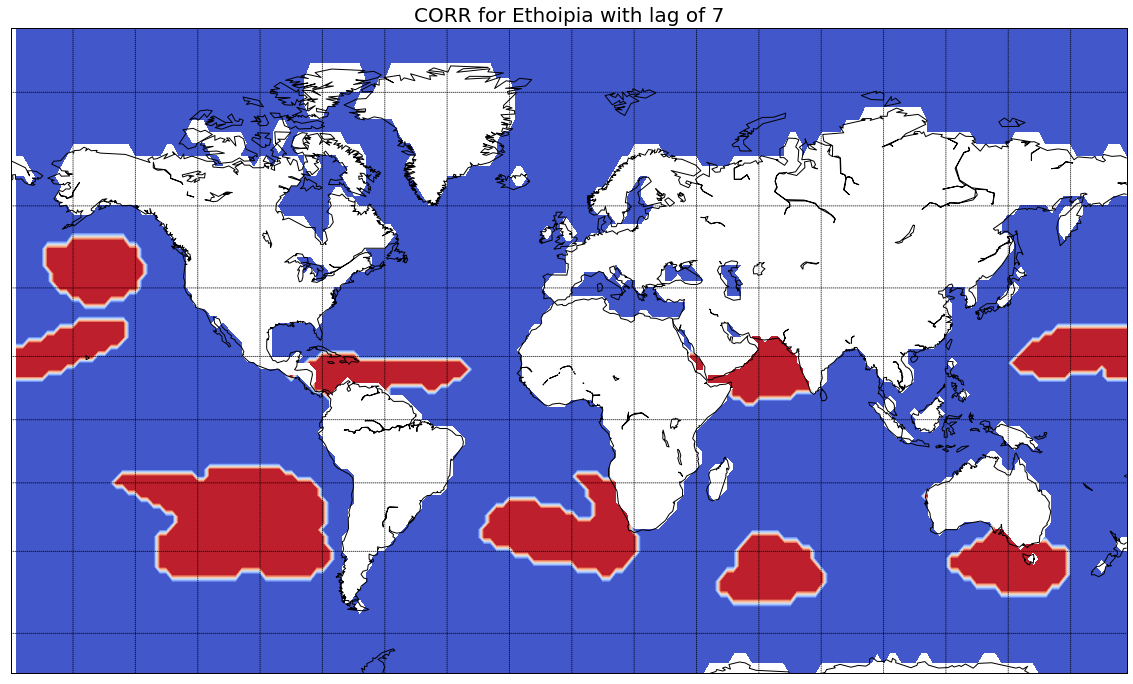

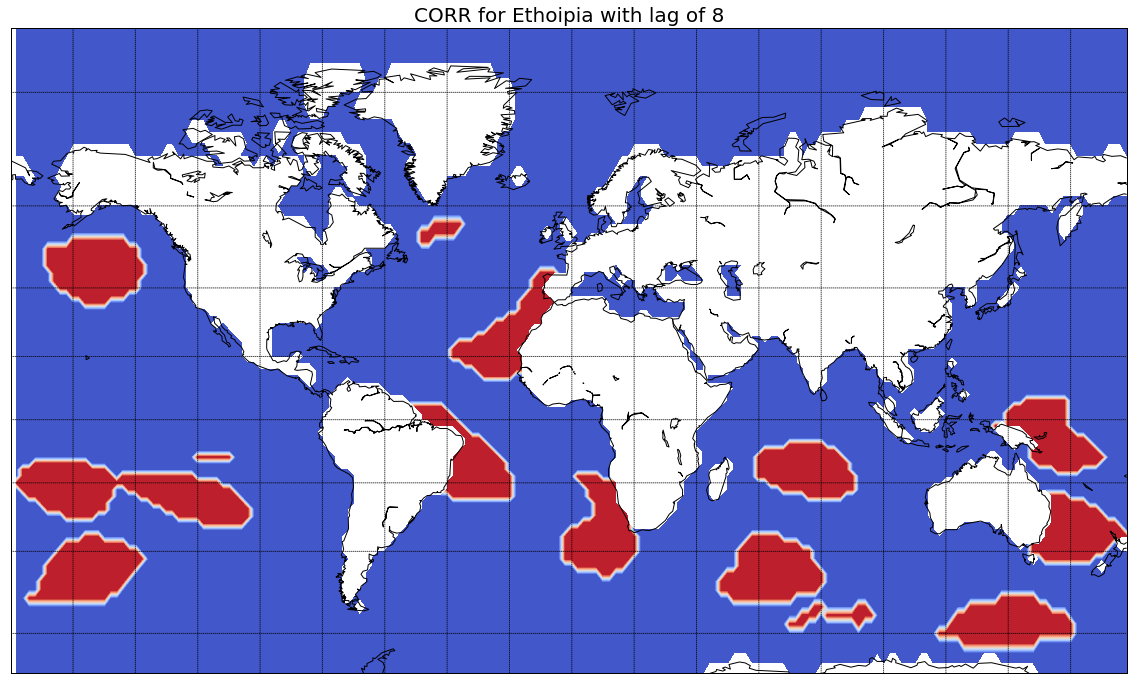

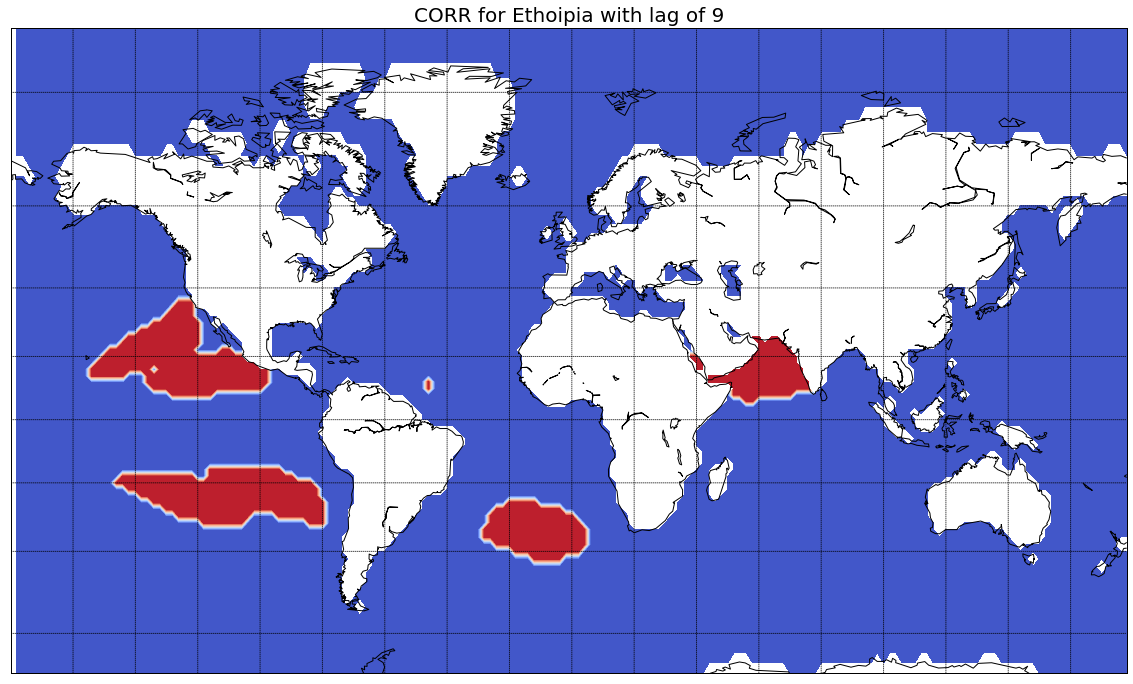

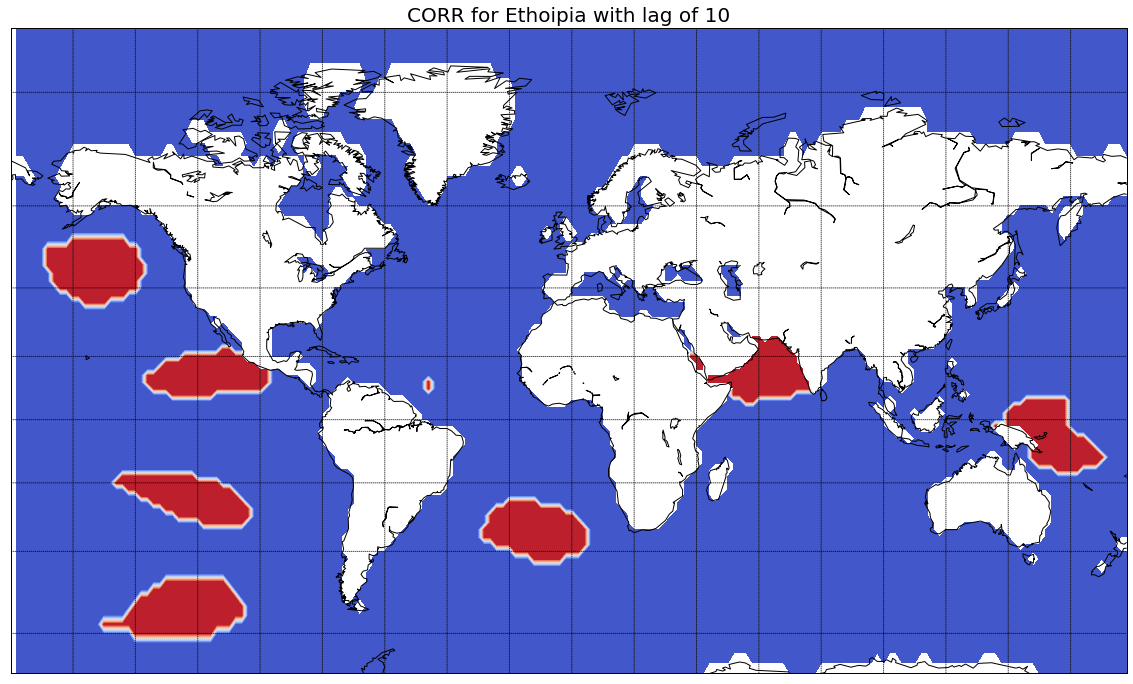

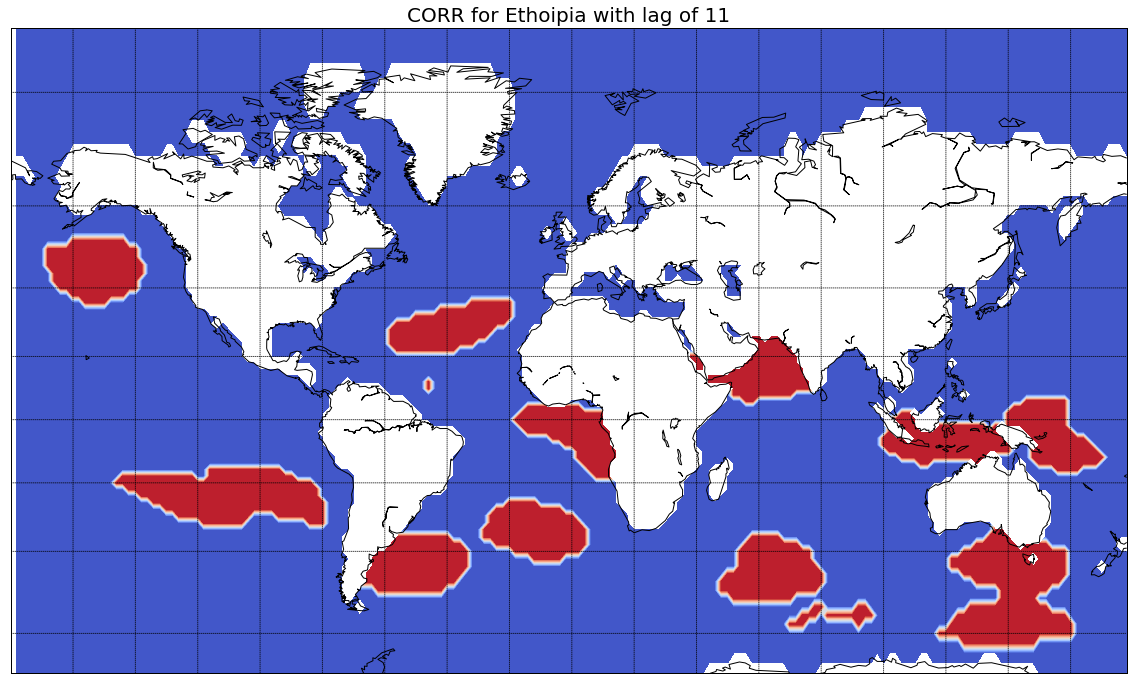

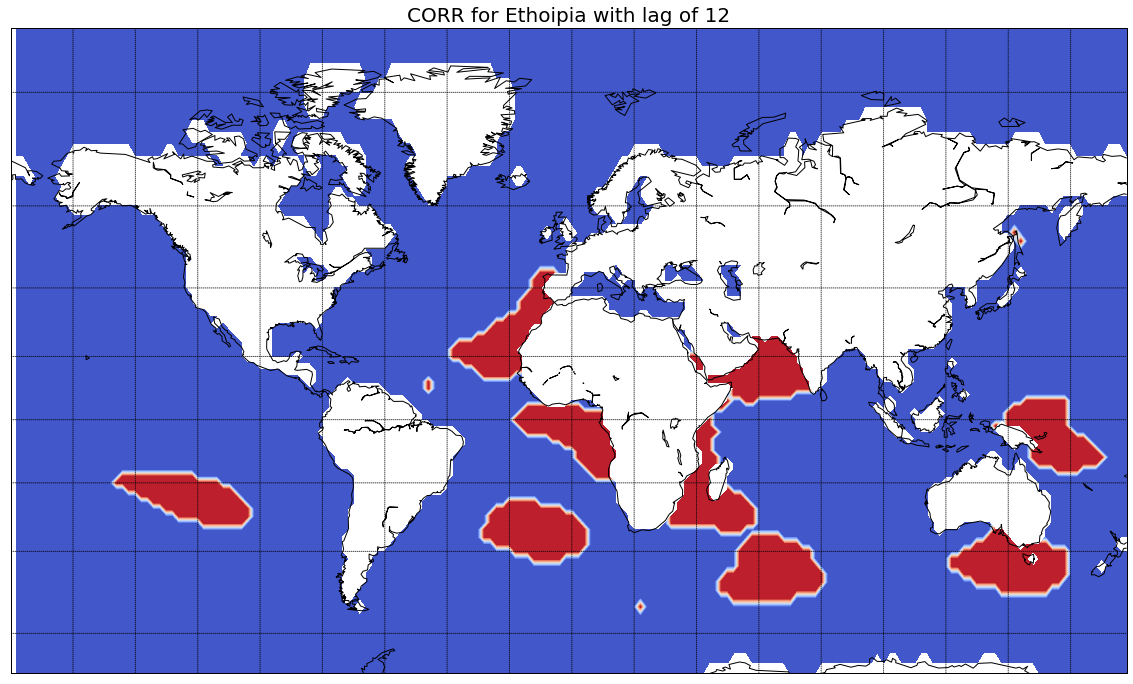

In [10]:
for tau in np.arange(1,13):
    pcmci = np.load("../../whole_data_results/ZW/best_link/corr_{}_{}_{}_{}_{}.npy".format(f,train_start,validation_end,tau,n_components_sst))
    comps = pcmci[:,0]
    level = 99

    lon1_sst = np.arange(-180,180,2)

    deg_result = np.zeros((len(lat_sst),len(lon1_sst)))

    lat_number = deg_result.shape[0]
    lon_number = deg_result.shape[1]

    for comp in set(comps):
        deg = np.zeros((len(lat_sst),len(lon1_sst)))
        df_sst["pc"] = Vr[:,comp-1]
        for i in range(lat_number):
            for j in range(lon_number):
                if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                    deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
                else:
                    deg[i,j]=np.nan


        if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
            limit = np.nanpercentile(deg, 1 - level)
            deg[deg>=limit]=0
            deg[deg<limit]=1
        else:
            limit = np.nanpercentile(deg, level)
            deg[deg<=limit]=0
            deg[deg>limit]=1

        deg_result = deg_result + deg
    
    deg_result[deg_result > 0] = 1

    lon  = lon1_sst
    lat = lat_sst
    m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
      urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
      resolution='c')

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2, lat2)
    x, y = m(lon2, lat2)
    fig = plt.figure(figsize=(20,15))
    #m.fillcontinents(color='gray',lake_color='gray')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    cs = m.contourf(x,y,deg_result,20,cmap=plt.cm.get_cmap('coolwarm'))
    plt.title('CORR for Ethoipia with lag of {}'.format(tau),fontsize=20)
    #cbar.ax.tick_params(labelsize=25)
    #plt.colorbar();
    #plt.savefig("EOF{}.png".format(pc))
    plt.savefig("./areas/{}_CORR_{}.png".format(cc,tau))
    

In [44]:
comps = pcmci[:,0]

In [45]:
level = 99

lon1_sst = np.arange(-180,180,2)

deg_result = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg_result.shape[0]
lon_number = deg_result.shape[1]

for comp in set(comps):
    deg = np.zeros((len(lat_sst),len(lon1_sst)))
    df_sst["pc"] = Vr[:,comp-1]
    for i in range(lat_number):
        for j in range(lon_number):
            if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
            else:
                deg[i,j]=np.nan
    

    if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
        limit = np.nanpercentile(deg, 1 - level)
        deg[deg>=limit]=0
        deg[deg<limit]=1
    else:
        limit = np.nanpercentile(deg, level)
        deg[deg<=limit]=0
        deg[deg>limit]=1
        
    deg_result = deg_result + deg

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


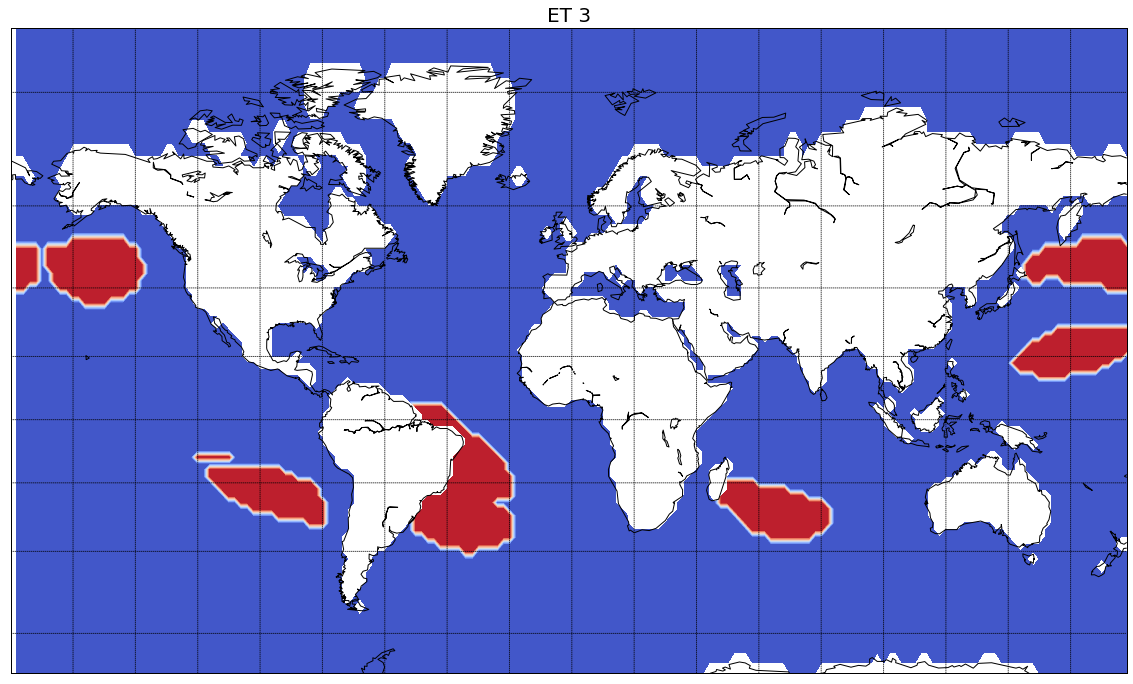

In [46]:
deg_result[deg_result > 0] = 1

lon  = lon1_sst
lat = lat_sst
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
  urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg_result,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.title('{} {}'.format(cc,tau),fontsize=20)
#cbar.ax.tick_params(labelsize=25)
#plt.colorbar();
#plt.savefig("EOF{}.png".format(pc))
plt.savefig("./areas/PCMCI_{}_{}.png".format(cc,tau))